**CHANGE LOG**

20 March 2018: 

- change one testing code in RNN forward section from `h0=np.random.uniform(size=(N, H))` to `h0=np.random.uniform(size=(H,))`, because the shape of RNN initial state `h0` shall not be dependent on the batch size.

- correct and clean up some comments in `rnn_layers.py`.

21 March 2018:

- strengthen the function `rel_error(x, y)` to check whether both `x` and `y` have `NaN` or not in corresponding position, which will help you debug the codes. **Since the later parts of this assignment are based on the former parts, make sure your implementation fully pass the current test case and then proceed to the next test case.**

- improve the keras part in the forward section of Bidirectional RNN, so that its output is padded by `NaN` as expected.

- change `datasets.py` to always rebuild dictionary.

30 March 2018:

- add more explanations for NaN handling in RNN Cell section.

- change the shape of `h0` and `hr` in the testing code of Bidirectinal RNN to be consistent with the one of RNN, i.e. `size=(H,)`. This change should not affect those who have passed the test case.

# Introduction

**ASSIGNMENT DEADLINE: 2 APRIL 2018 (MON) 17:00PM**

In this assignment we will be coding the building blocks for the Recurrent Neural Network (RNN) in `rnn_layers.py` and putting them together to train a RNN on sentiment analysis. 

**Attention: Only python3 will be allowed to use in this assignment. And we use numpy to store and caculate data and parameters. You do not need a GPU for this assignment. CPU is enough. To run this Jupyter notebook, you need to install the depedent libraries in [requiremets.txt](requirements.txt) via pip (or pip3). Note: If you don't implement all the codes, running the codes might occur some errors.**

For each layer we will implement a forward and a backward function. The forward function will receive inputs and will return the outputs of this layer(loss layer will be a little different), and the backward pass will receive upstream derivatives and inputs and will return gradients with respect to the inputs. Gradients for weights or bias will be stored in parameters in this layer:

```python
class SomeLayer(Layer):
    # some layer type inherited from Layer class
    def __init__(self, params):
        # set up specific layer parameters
        # initialize variables for the layer weights
        # initialize variables for storing the gradients
        # initialize other necessary variables
    def forward(self, inputs):
        # Receive inputs and return output
        # Do some computations ...
        z = # ... some intermediate value
        # Do some more computations ...
        outputs = # the outputs
        return outputs
    def backward(self, in_grads, inputs):
        # Receive derivative of loss with respect to outputs,
        # and compute derivative with respect to inputs.
        # Use values in cache to compute derivatives
        out_grads = # Derivative of loss with respect to inputs
        self.w_grad = # Derivative of loss with respect to self.weights
        return out_grads
```

After implementing a bunch of layers (i.e. `RNN Cell`, `RNN`, `Bidirectional RNN`) in this way, we will be able to easily combine them to build classifiers for various applications whose input are sequential data (e.g. Sentiment Analysis).

This iPython notebook serves to:
- explain the questions
- explain the function APIs and implementation examples
- provide helper functions to piece functions together and check your code

# RNN Cell Layer

RNN cell is the basic building block of RNN, which implements the specific operation at each time step of RNN. It has an hidden states of dimension `H` and accepts inputs of dimension `D`. In this assignment, you are required to implement a simple type of RNN cell, formulated as follows:

\begin{equation*}
y=tanh(Wx+Uh+b),
\end{equation*}

where `x` and `h` are the inputs and hidden states respectively, and `W`, `U` and `b` are trainable kernel, recurrent_kernel and bias respectively.

## Forward

Please implement the function `RNNCell.forward(self, inputs)` and test your implementation using the following code. (`inputs` is a list of two numpy arrays, `[x, h]`).

In [1]:
import numpy as np
import keras
from keras import layers
import importlib
import rnn_layers
importlib.reload(rnn_layers)
from rnn_layers import RNNCell
from utils.tools import rel_error

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
out = rnn_cell.forward([x, prev_h])
# compare with the keras implementation
keras_x = layers.Input(shape=(1, D), name='x')
keras_prev_h = layers.Input(shape=(H,), name='prev_h')
keras_rnn = layers.RNN(layers.SimpleRNNCell(H),
                       name='rnn')(keras_x, initial_state=keras_prev_h)
keras_model = keras.Model(inputs=[keras_x, keras_prev_h], 
                          outputs=keras_rnn)
keras_model.get_layer('rnn').set_weights([rnn_cell.kernel,
                                          rnn_cell.recurrent_kernel,
                                          rnn_cell.bias])
keras_out = keras_model.predict_on_batch([x[:, None, :], prev_h])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

C:\Users\WeitaoYang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Relative error (<1e-5 will be fine): 7.43198803205293e-08


## Backward

Please implement the function `RNNCell.backward(self, in_grads, inputs)` and test your implementation using the following code. You need to compute the gradients to both the inputs and hidden states, as well as those trainable weights.

In [2]:
import numpy as np
import importlib
import rnn_layers
importlib.reload(rnn_layers)
from rnn_layers import RNNCell
from utils.check_grads import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
check_grads_layer(rnn_cell, [x, prev_h], in_grads)

<1e-8 will be fine
Gradients to inputs 0: 1.3497407042406637e-11
Gradients to inputs 1: 1.4797080866051084e-11
Gradients to -:rnn_cell/kernel: 1.4334318178271783e-11
Gradients to -:rnn_cell/recurrent_kernel: 1.4506290737853266e-11
Gradients to -:rnn_cell/bias: 2.7120237949730768e-11


Then please improve your implementation of RNN cell so that it can properly handle `NaN` input, and test it with the following code. **In forward pass, the corresponding output units are supposed to be `NaN` as well; in backward pass, the gradients to those `NaN` input units are supposed to be zeros.**

In [3]:
import numpy as np
import importlib
import rnn_layers
importlib.reload(rnn_layers)
from rnn_layers import RNNCell
from utils.check_grads import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
# set part of input to NaN
# this situation will be encountered in the following work
x[1:, :] = np.nan
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
check_grads_layer(rnn_cell, [x, prev_h], in_grads)

<1e-8 will be fine
Gradients to inputs 0: 1.1886656208182732e-11
Gradients to inputs 1: 8.706672289121517e-12
Gradients to -:rnn_cell/kernel: 2.1056394453457625e-11
Gradients to -:rnn_cell/recurrent_kernel: 1.5632203448684365e-11
Gradients to -:rnn_cell/bias: 3.2895184840985206e-11


# RNN Layer

RNN layer wraps any type of RNN cell so that it can operate over a sequence of input data of different length. In particular, it runs a instance of RNN cell over the inputs, holds and updates the hidden states for the RNN cell. In this assignment, you are required to implement such a general RNN layer that is able to wrap your implemented RNN cell above.

## Forward

Please implement the function `RNN.forward(self, inputs)` and test your implementation using the following code. Since NN layers generally proceed on a batch of data simultaneously, and for RNN, each input data may have different length, we define the input data format as an array of `(N, T, D)`, where `N` is the number of samples in a batch, `T` is the maximum length of input sequences, and `D` is the dimension of features at each time step. `NaN` is used to pad input sequences of different lenghts, so that the resulting length equals to `T`, e.g. `(x1, x2, ..., xk, NaN, NaN)`. **Tips: you can utilze `np.nan_to_num(x)` to easily convert NaNs to zeros in a numpy array, and `np.isnan(x)` to get binary mask indicating which elements are NaNs.**

In [4]:
import numpy as np
import keras
from keras import layers
import importlib
import rnn_layers
importlib.reload(rnn_layers)
from rnn_layers import RNNCell, RNN
from utils.tools import rel_error

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))

rnn_cell = RNNCell(in_features=D, units=H)
rnn = RNN(rnn_cell, h0=h0)
out = rnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True,
                       name='rnn')(keras_x, initial_state=keras_h0)
keras_model = keras.Model(inputs=[keras_x, keras_h0],
                          outputs=keras_rnn)
keras_model.get_layer('rnn').set_weights([rnn.kernel,
                                          rnn.recurrent_kernel,
                                          rnn.bias])
keras_out = keras_model.predict_on_batch([x, np.tile(h0, (N, 1))])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 6.991196112056631e-08


C:\Users\WeitaoYang\Desktop\assignment2_v4\assignment2_v4\codes\utils\tools.py:54: RuntimeWarning: invalid value encountered in maximum
  rel_error = np.abs(x-y)/(np.maximum(1e-8, np.abs(x)+np.abs(y)))


## Backward

Please implement the function `RNN.backward(self, in_grads, inputs)` and test your implementation using the following code (**note the internal gradients passed from next time steps**). Once again: the gradients to those `NaN` input units are supposed to be zeros

In [5]:
import numpy as np
import importlib
import rnn_layers
importlib.reload(rnn_layers)
from rnn_layers import RNNCell, RNN
from utils.check_grads import check_grads_layer

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
in_grads = np.random.uniform(size=(N, T, H))

rnn_cell = RNNCell(in_features=D, units=H)
rnn = RNN(rnn_cell)
check_grads_layer(rnn, x, in_grads)

<1e-8 will be fine
Gradients to inputs: 7.262078645807572e-12
Gradients to -:rnn/kernel: 1.0015206178132202e-11
Gradients to -:rnn/recurrent_kernel: 5.116703611058533e-12
Gradients to -:rnn/bias: 3.066715936615068e-11


# Bi-directional RNN Layer

Vallina RNN operates over input sequence in one direction, so it has limitations as the future input information cannot be reached from the current state. On the contrary, Bi-directional RNN addresses this shortcoming by operating the input sequence in both forward and backward directions. 

Usually, Bi-directional RNN is implemented by running two independent RNNs in opposite direction of input data, and concatenating the outputs of the two RNNs. Since you have implemented RNN layer above, implementing Bi-directional RNN layer is not hard, which just requires certain manipulation of input data. A useful function that can reverse a batch of sequence data is provided for your easy implementation.

```python
def _reverse_temporal_data(self, x, mask):
    num_nan = np.sum(~mask, axis=1)
    reversed_x = np.array(x[:, ::-1, :])
    for i in range(num_nan.size):
        reversed_x[i] = np.roll(reversed_x[i], x.shape[1]-num_nan[i], axis=0)
    return reversed_x
```

## Forward

We provided the function `BidirectionalRNN.forward(self, inputs)` and the following code for testing. Note that `H` is the dimension of the hidden states of one internal RNN, so the actual dimension of the hidden states (or outputs) of Bidirectional RNN is `2*H`.

In [6]:
import numpy as np
import keras
from keras import layers
import importlib
import rnn_layers
importlib.reload(rnn_layers)
from rnn_layers import RNNCell, BidirectionalRNN
from utils.tools import rel_error

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))
hr = np.random.uniform(size=(H,))

rnn_cell = RNNCell(in_features=D, units=H)
brnn = BidirectionalRNN(rnn_cell, h0=h0, hr=hr)
out = brnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_hr = layers.Input(shape=(H,), name='hr')
keras_x_masked = layers.Masking(mask_value=0.)(keras_x)
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True)
keras_brnn = layers.Bidirectional(keras_rnn, merge_mode='concat', name='brnn')(
        keras_x_masked, initial_state=[keras_h0, keras_hr])
keras_model = keras.Model(inputs=[keras_x, keras_h0, keras_hr],
                          outputs=keras_brnn)
keras_model.get_layer('brnn').set_weights([brnn.forward_rnn.kernel,
                                           brnn.forward_rnn.recurrent_kernel, 
                                           brnn.forward_rnn.bias,
                                           brnn.backward_rnn.kernel, 
                                           brnn.backward_rnn.recurrent_kernel,
                                           brnn.backward_rnn.bias])
keras_out = keras_model.predict_on_batch([np.nan_to_num(x), np.tile(h0, (N, 1)), np.tile(hr, (N, 1))])
nan_indices = np.where(np.any(np.isnan(x), axis=2))
keras_out[nan_indices[0], nan_indices[1], :] = np.nan

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 8.882761854292571e-08


C:\Users\WeitaoYang\Desktop\assignment2_v4\assignment2_v4\codes\utils\tools.py:54: RuntimeWarning: invalid value encountered in maximum
  rel_error = np.abs(x-y)/(np.maximum(1e-8, np.abs(x)+np.abs(y)))


## Backward

Please refer to the provided forward function and implement the function `BidirectionalRNN.backward(self, inputs)`. Test your implementation using the following code.

In [7]:
import numpy as np
import importlib
import rnn_layers
importlib.reload(rnn_layers)
from rnn_layers import RNNCell, BidirectionalRNN
from utils.check_grads import check_grads_layer

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
in_grads = np.random.uniform(size=(N, T, H*2))

rnn_cell = RNNCell(in_features=D, units=H)
brnn = BidirectionalRNN(rnn_cell)
check_grads_layer(brnn, x, in_grads)

<1e-8 will be fine
Gradients to inputs: 5.925223341487433e-12
Gradients to -:brnn/forward_kernel: 2.00516419195269e-11
Gradients to -:brnn/forward_recurrent_kernel: 3.69196475112952e-12
Gradients to -:brnn/forward_bias: 3.055104033377695e-11
Gradients to -:brnn/backward_kernel: 1.981331701660495e-11
Gradients to -:brnn/backward_recurrent_kernel: 6.168163874263375e-12
Gradients to -:brnn/backward_bias: 3.065512135272284e-11


# Sentiment Analysis using RNNs

In this section, you are required to test your implementations above by running an ensemble NN on a sentiment analysis dataset. The dataset, `data/corpus.csv`, consists of 800 real movie comments and the corresponding labels that indicate whether the comments are positive or negative. For example:
```
POSTIVE: I absolutely LOVE Harry Potter, as you can tell already.
NEGATIVE: My dad's being stupid about brokeback mountain...
```

We provide a basic NN for your experiments, which can be found in `applications.py`. The architecture is as follow:
```python
FCLayer(vocab_size, 200, name='embedding')
BidirectionalRNN(RNNCell(in_features=200, units=50))
FCLayer(100, 32, name='fclayer1')
TemporalPooling()
FCLayer(32, 2, name='fclayer2')
```
The input to the network is sequences of one-hot vectors, each of which represents a word. The 1st FC layer works as an [embedding layer](https://www.tensorflow.org/versions/master/programmers_guide/embedding) to learn and retrieve the word embedding vectors. After a Bi-directional RNN layer and another FC layer, a TemporalPooling layer (see `layers.py`) is used to mean-pooling a sequence of vectors into one vector, which will ignore the filling `NaN`s. The rest of the network is same as a normal NN classifier.

In [1]:
from utils import datasets
from applications import SentimentNet
from loss import SoftmaxCrossEntropy, L2
from optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.001, decay=0,
            scheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=5, 
        val_intervals=100, test_intervals=300, print_intervals=5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WeitaoYang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Number of training samples: 600
Number of validation samples: 100
Number of testing samples: 100
Epoch 0: 
Test accuracy=0.41000, loss=0.69315
Validation accuracy: 0.48000, loss: 0.69315
Iteration 0:	accuracy=0.20000, loss=0.69315, regularization loss= 0.010912504407227535
Iteration 5:	accuracy=0.65000, loss=0.69146, regularization loss= 0.0042538800391660764
Iteration 10:	accuracy=0.70000, loss=0.68808, regularization loss= 0.0026528293960379253
Iteration 15:	accuracy=0.50000, loss=0.69326, regularization loss= 0.0025689034993727267
Iteration 20:	accuracy=0.65000, loss=0.68520, regularization loss= 0.002631591820642612
Iteration 25:	accuracy=0.65000, loss=0.68039, regularization loss= 0.0030224863072591634
Epoch 1: 
Test accuracy=0.60000, loss=0.68092
Validation accuracy: 0.58000, loss: 0.68310
Iteration 0:	accuracy=0.45000, loss=

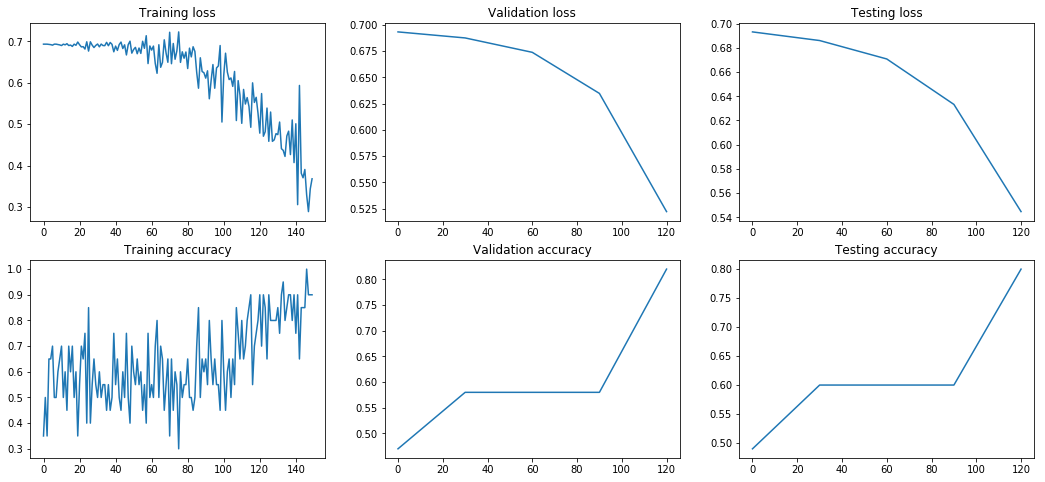

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(2, figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 3, 4)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 3, 2)
plt.title('Validation loss')
plt.plot(val_results[:,0], val_results[:,1])
plt.subplot(2, 3, 5)
plt.title('Validation accuracy')
plt.plot(val_results[:,0], val_results[:,2])
plt.subplot(2, 3, 3)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 3, 6)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

## Train your best Sentiment Analysis net
Based on the provided NN, tweak the hyperparameters and use what you've learnt to train the best net on sentiment analysis (you should not need to wait half a day for the training to complete). You are free to use more features, hidden units, layers etc. In your report, please write the following:
- Training and test accuracy over iterations
- Architecture and training method (eg. optimization scheme, data augmentation): explain your design choices, what has failed and what has worked and why you think they worked/failed

Credits will be given based on your test accuracy and explanation on your network architecture and training method. Large component of the grading will subject to the latter. Use only the code you have written and any helper functions provided in this assignment and **assignment 1**. Do not use external libraries like Tensorflow and Pytorch.

# Final submission instructions
Upon completion, please submit the following:
- Your code files in a folder `codes`;
- A short report (1-2 pages) in pdf titled `report.pdf`, explaining the logic (expressed using mathematical formulation) of your implementation (including the forward and backward function like ReLU) and the findings from training your best net.

Please zip up the abovementioned files under a folder named with your NUSNET ID: eg. `e0123456.zip' and submit the zipped folder to IVLE/workbin/assignment 2 submission. The submission deadline is 2 APRIL 2018 (MON) 17:00PM.